In [3]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from IPython.display import display, HTML
from typing import List
import numpy as np
from copy import deepcopy
# import sasc.notebook_helper
import sasc.viz
import scipy.special
from collections import defaultdict
from pprint import pprint
import sasc.analyze_helper
import joblib
# import viz
from sasc.config import RESULTS_DIR

# setting = 'default'
setting = 'roi'
MAIN_DIR = join(RESULTS_DIR, 'stories', setting)
EXPT_DIRS = sorted([join(MAIN_DIR, dir_name) for dir_name in os.listdir(MAIN_DIR)])
EXPT_DIRS = [x for x in EXPT_DIRS if 'uts03' in x.lower() or 'uts01' in x.lower()]
# EXPT_DIRS = [x for x in EXPT_DIRS if 'uts02' in x.lower()]
# EXPT_DIRS = [x for x in EXPT_DIRS if 'uts01' in x.lower()]
EXPT_DIR = EXPT_DIRS[0]

# things are precomputed using 02_process_story, so we don't need this now
# rows = joblib.load(join(EXPT_DIR, f'rows.pkl'))
# expls = rows.expl.values
# try:
    # prompts_paragraphs = joblib.load(
        # join(EXPT_DIR, "prompts_paragraphs.pkl"),
    # )
    # prompts = prompts_paragraphs["prompts"]
    # paragraphs = prompts_paragraphs["paragraphs"]
# except:
    # prompts = open(join(EXPT_DIR, "prompts.txt"), 'r').read().split('\n\n')
    # paragraphs = open(join(EXPT_DIR, "story.txt"), 'r').read().split('\n\n')
    # assert len(prompts) == len(paragraphs), f"{len(prompts)} != {len(paragraphs)}"
# voxel_nums = rows.module_num.values
# subjects = rows.subject.values

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/chansingh/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
EXPT_DIRS

['/home/chansingh/automated-explanations/results/stories/roi/uts03___roi_may31___seed=1',
 '/home/chansingh/automated-explanations/results/stories/roi/uts03___roi_may31___seed=2',
 '/home/chansingh/automated-explanations/results/stories/roi/uts03___roi_may31___seed=3',
 '/home/chansingh/automated-explanations/results/stories/roi/uts03___roi_may31___seed=4',
 '/home/chansingh/automated-explanations/results/stories/roi/uts03___roi_may31___seed=5',
 '/home/chansingh/automated-explanations/results/stories/roi/uts03___roi_may31___seed=6',
 '/home/chansingh/automated-explanations/results/stories/roi/uts03___roi_may31___seed=7',
 '/home/chansingh/automated-explanations/results/stories/roi/uts03___roi_may31___seed=8',
 '/home/chansingh/automated-explanations/results/stories/roi/uts03___roi_may31___seed=9']

### Heatmaps

**Data** <> Story Heatmap

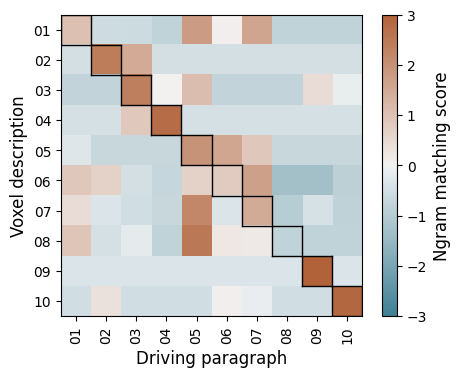

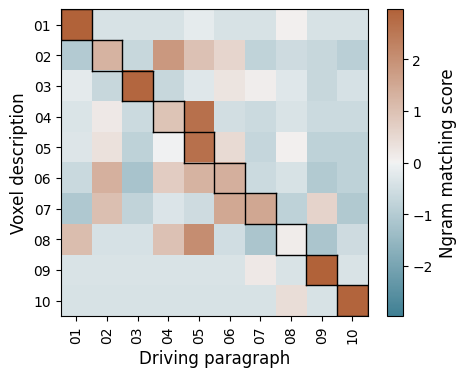

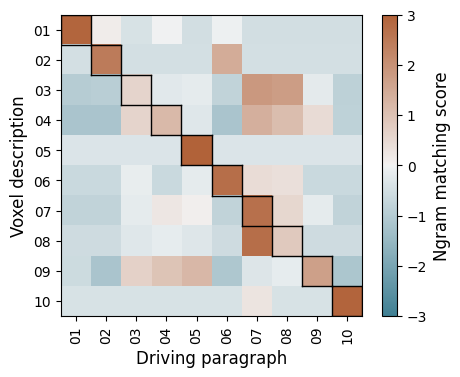

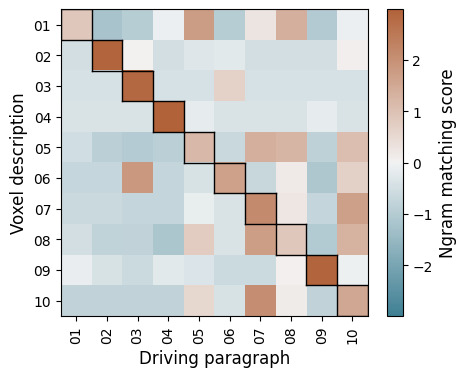

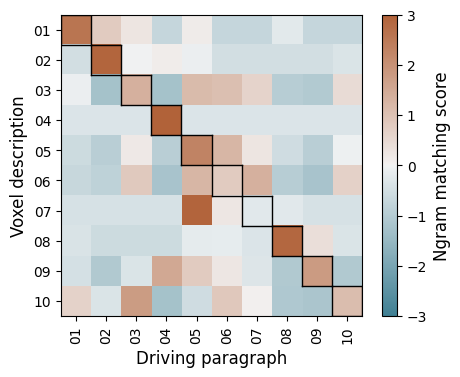

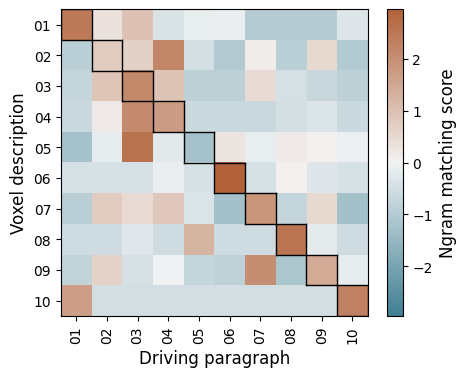

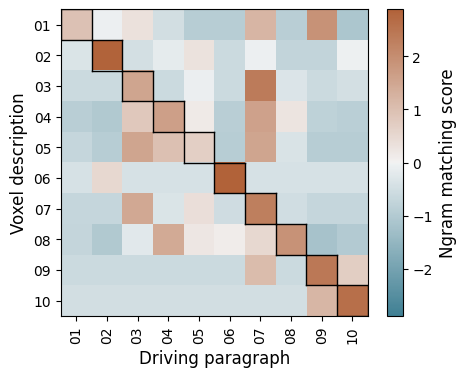

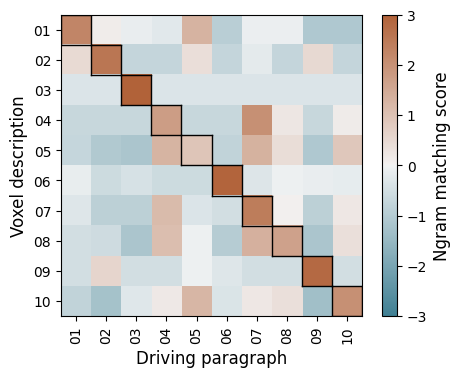

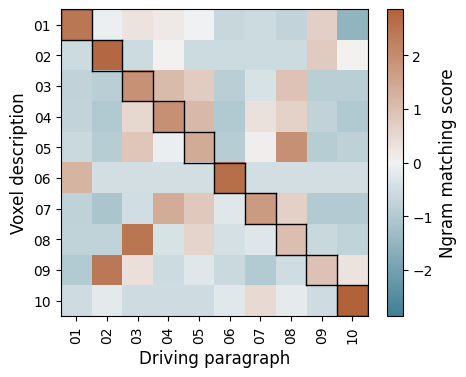

In [5]:
order_final = False

for EXPT_DIR in EXPT_DIRS:
    try:
        d = joblib.load(join(EXPT_DIR, "scores_data.pkl"))
    except:
        print('skipping', EXPT_DIR)
        continue
    s = d["scores_mean"].T
    # normalize each column
    s = (s - s.mean(axis=0)) / \
        s.std(axis=0)
    s = s.T

    try:
        rows = joblib.load(join(EXPT_DIR, f"rows.pkl"))
    except:
        rows = pd.read_csv(join(EXPT_DIR, f"rows.csv"))
    # rows = joblib.load(join(EXPT_DIR, f"rows.pkl"))
    expls = rows.expl.values
    if order_final:
        expls_order = np.argsort(expls)
        expls_order = expls_order[[15, 7, 11, 14, 3,
                                   12, 4, 1, 2, 0, 13, 6, 5, 16, 10, 9, 8]]
    else:
        if setting == 'default':
            expls_order = sasc.analyze_helper.sort_expls_semantically(expls)
            s = s[expls_order][:, expls_order]  # [:, expls_order]
            expls = expls[expls_order]
    # {"scores_mean": scores_mean, "scores_all": scores_all},
    sasc.viz.heatmap(s, expls, ylab="Voxel description", diverging=True,
                     xlab="Driving paragraph", clab='Ngram matching score', label_fontsize='large')
    sasc.viz.outline_diagonal(s.shape, color='black', lw=1, block_size=1)
    labs = [f'{i + 1:02d}' for i in range(len(expls))]
    fontsize = 'medium'
    plt.yticks(labels=labs, ticks=np.arange(
        len(labs)), fontsize=fontsize)
    plt.xticks(labels=labs, ticks=np.arange(
        len(labs)), rotation=90, fontsize=fontsize)

    plt.savefig(join(EXPT_DIR, f"story_data_match.pdf"), bbox_inches="tight")

**Module** <> Story Heatmap

<>:26: DeprecationWarning: invalid escape sequence '\s'
<>:26: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_584146/53544675.py:26: DeprecationWarning: invalid escape sequence '\s'
  xlab="Driving paragraph", label_fontsize='large', clab='Mean model response ($\sigma$)')


{'uts03___roi_may31___seed=1': 1.08568,
 'uts03___roi_may31___seed=2': 1.186,
 'uts03___roi_may31___seed=3': 1.1763,
 'uts03___roi_may31___seed=4': 1.25946,
 'uts03___roi_may31___seed=5': 1.23291,
 'uts03___roi_may31___seed=6': 1.27937,
 'uts03___roi_may31___seed=7': 1.20034,
 'uts03___roi_may31___seed=8': 1.1695,
 'uts03___roi_may31___seed=9': 1.13094}

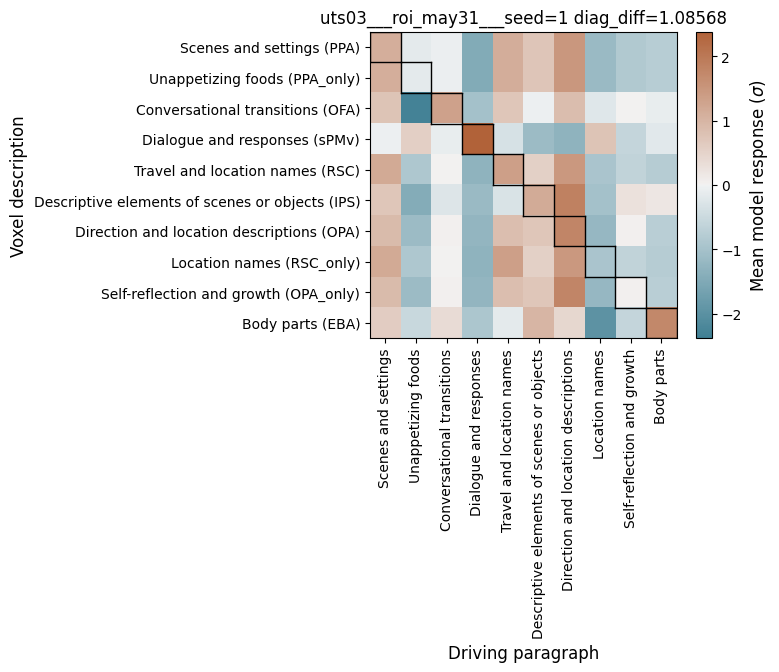

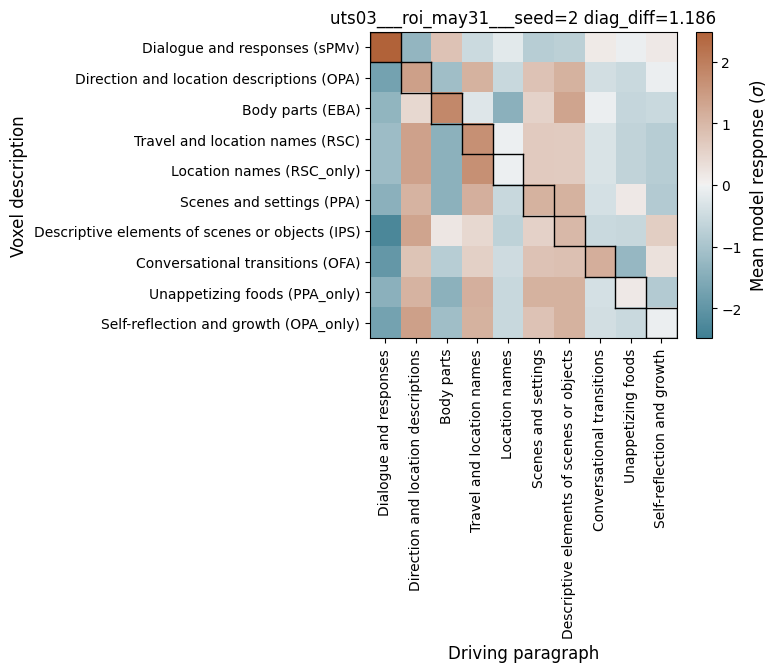

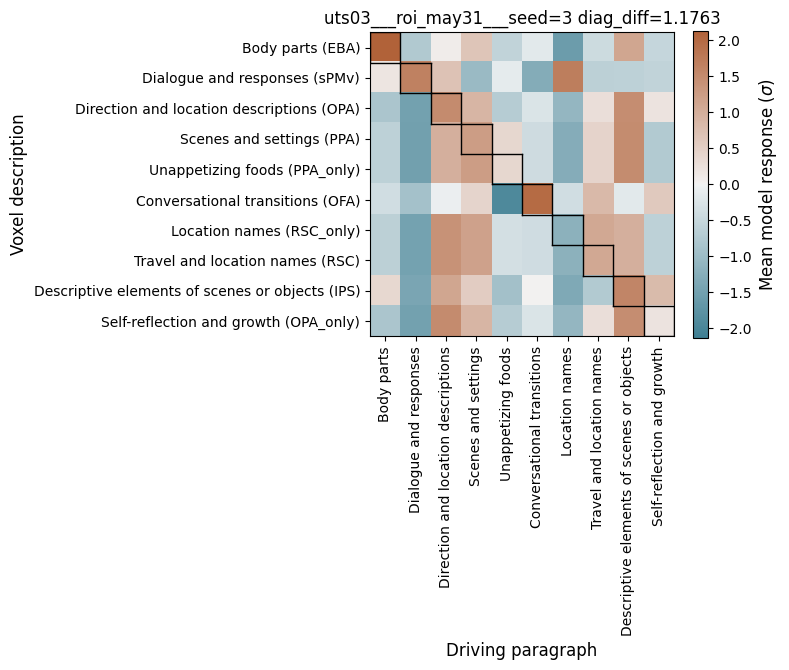

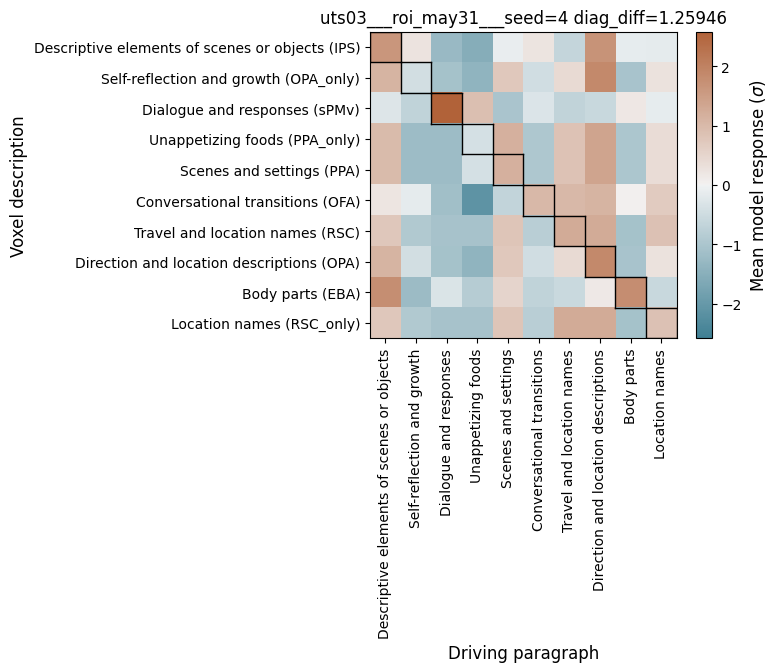

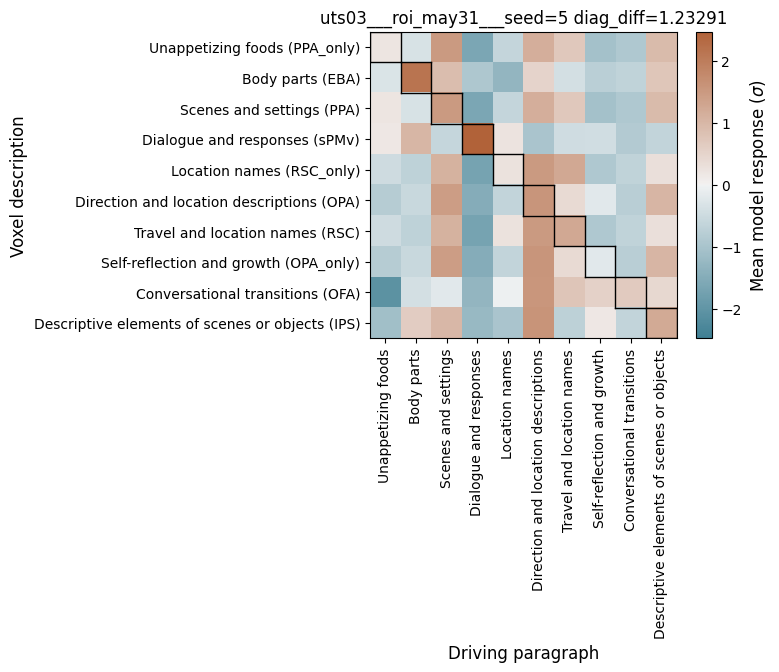

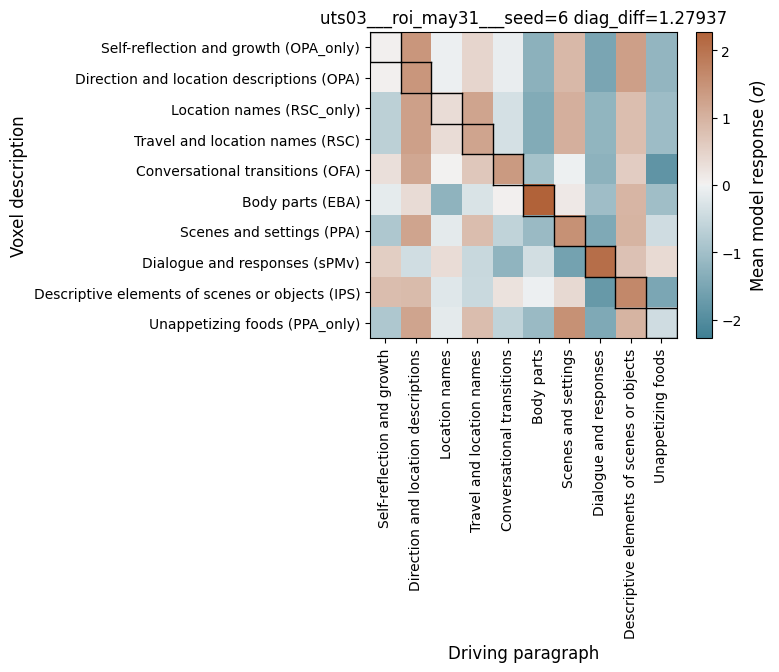

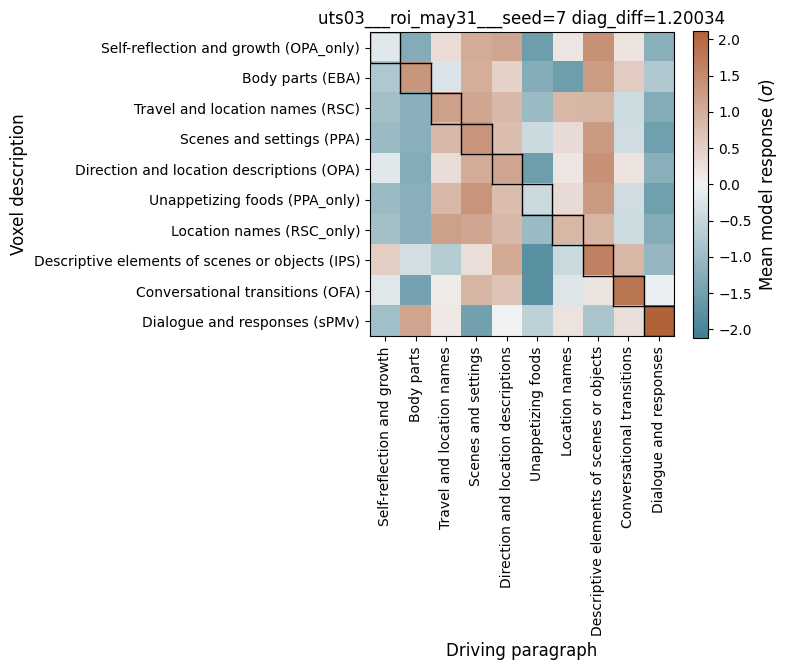

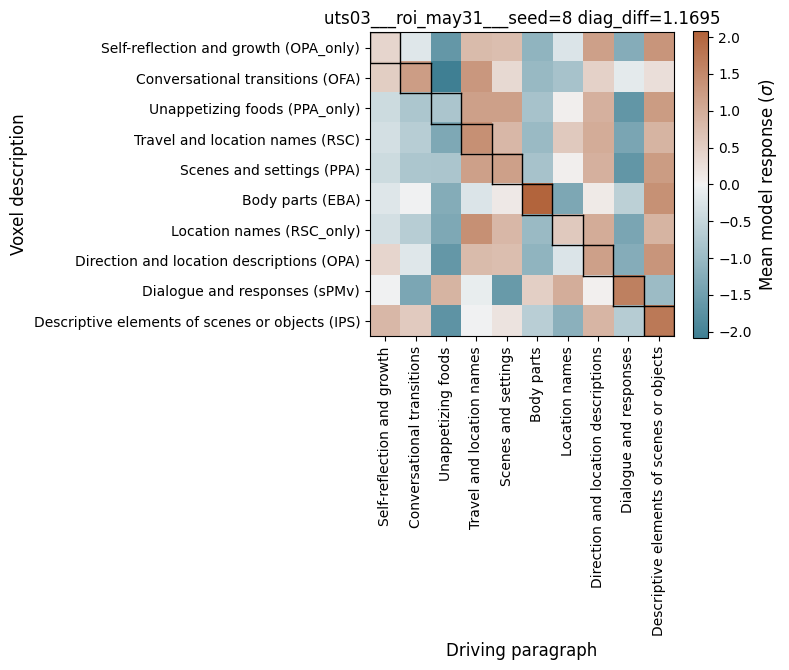

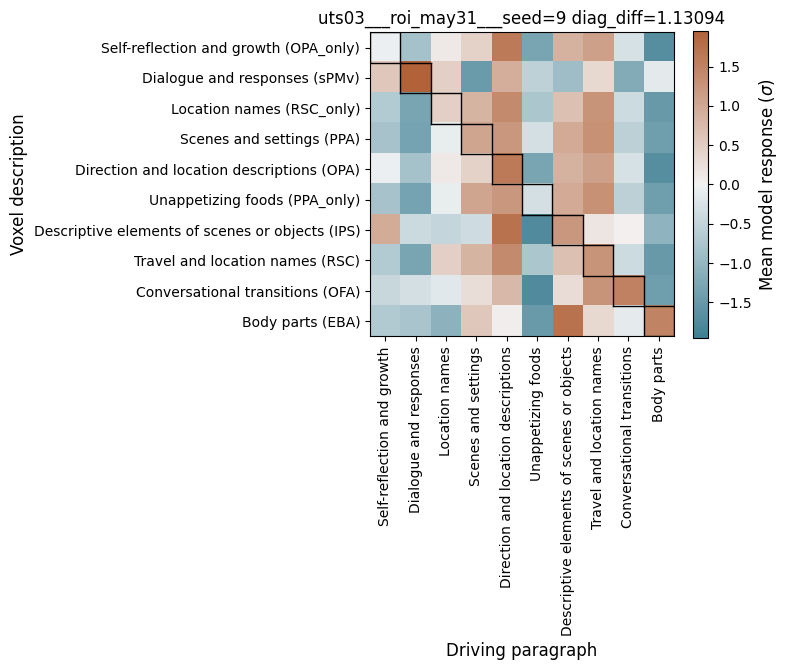

In [7]:
res = {}
for EXPT_DIR in EXPT_DIRS:
    scores_data = joblib.load(
        join(EXPT_DIR, f"scores_mod_ngram_length={0}.pkl"))
    s = scores_data["scores_mean"].T
    # z-score each column
    s = (s - s.mean(axis=0)) / s.std(axis=0)
    s = s.T

    # s = scipy.special.softmax(s, axis=0)
    # s = (s - s.min()) / (s.max() - s.min())
    # rows = joblib.load(join(EXPT_DIR, f'rows1_rep.pkl'))
    try:
        rows = joblib.load(join(EXPT_DIR, f"rows.pkl"))
    except:
        rows = pd.read_csv(join(EXPT_DIR, f"rows.csv"))
    expls = rows.expl.values

    if setting == 'default':
        expls_order = sasc.analyze_helper.sort_expls_semantically(expls)
        s = s[expls_order][:, expls_order]  # [:, expls_order]
        expls = expls[expls_order]

    sasc.viz.heatmap(
        s, expls, ylab="Voxel description",
        xlab="Driving paragraph", label_fontsize='large', clab='Mean model response ($\sigma$)')
    sasc.viz.outline_diagonal(s.shape, color='black', lw=1, block_size=1)

    labs = [f'{i + 1:02d}' for i in range(len(expls))]
    fontsize = 'medium'
    # plt.yticks(labels=labs, ticks=np.arange(
    # len(labs)), fontsize=fontsize)
    # plt.xticks(labels=labs, ticks=np.arange(
    # len(labs)), rotation=90, fontsize=fontsize)
    rois = rows.roi.values
    plt.yticks(labels=[expls[i] + f' ({rois[i]})' for i in range(len(expls))], ticks=np.arange(
        len(labs)), fontsize=fontsize)
    plt.xticks(labels=expls, ticks=np.arange(
        len(labs)), rotation=90, fontsize=fontsize)
    # ax = plt.gca()
    # ax.yaxis.label.set_size('large')
    # ax.xaxis.label.set_size('large')
    # increase colorbar label size
    # cbar = ax.collections[0].colorbar
    # cbar.ax.tick_params(labelsize='large')

    # calculate mean of diagonal - mean of off-diagonal for s
    diag_diff = (
        np.mean(np.diag(s))
        - (
            np.mean(s[np.triu_indices_from(s, k=1)])
            + np.mean(s[np.tril_indices_from(s, k=-1)])
        )
        / 2
    ).round(5)
    # if not setting == 'default':
    plt.title(os.path.basename(EXPT_DIR) + ' diag_diff=' + str(diag_diff))
    res[os.path.basename(EXPT_DIR)] = diag_diff

    # plt.savefig(join(EXPT_DIR, f"story_module_match.png"), dpi=300)
    plt.savefig(join(EXPT_DIR, f"story_module_match.pdf"), bbox_inches="tight")
    # plt.tight_layout()
    # plt.show()
    # break
# sasc.viz.save_figs_to_single_pdf('../results/expl_story_match.pdf')
res

### Process encoding score averaged across stories

In [ ]:
setting = 'default'
MAIN_DIR = join(RESULTS_DIR, 'stories', setting)
EXPT_DIRS = sorted([join(MAIN_DIR, dir_name)
                   for dir_name in os.listdir(MAIN_DIR)])


dfs = []
for subject in ['uts01', 'uts03', 'uts02']:  # , 'uts02', 'uts03']:
    mats = []
    expt_dirs = [x for x in EXPT_DIRS if subject in x]
    res = {}

    for expt_dir in expt_dirs:

        scores_data = joblib.load(
            join(expt_dir, f"scores_mod_ngram_length={0}.pkl"))
        s = scores_data["scores_mean"].T
        # z-score each column
        s = (s - s.mean(axis=0)) / s.std(axis=0)
        s = s.T
        try:
            rows = joblib.load(join(expt_dir, f"rows.pkl"))
        except:
            rows = pd.read_csv(join(expt_dir, f"rows.csv"))
        module_nums = rows.module_num.values
        expls = rows.expl.values
        expls_order = np.argsort(expls)
        s = s[expls_order][:, expls_order]  # [:, expls_order]
        expls = expls[expls_order]
        module_nums = module_nums[expls_order]

        # sasc.viz.heatmap(s, expls, ylab="Voxel encoding model",
        #  xlab="Driving paragraph", label_fontsize='large', clab='Mean model response ($\sigma_f$)')
        mats.append(s)

    mat = np.array(mats).mean(axis=0)
    mat_diffs = []
    for i in range(mat.shape[0]):
        mat_diffs.append(
            mat[i][i] - (mat[i].sum() - mat[i][i]) / (mat.shape[0] - 1)
        )
    df = pd.DataFrame(mat_diffs, columns=['encoding_score'])
    df['expl'] = expls
    df['module_num'] = module_nums
    df['subject'] = subject
    dfs.append(df)
joblib.dump(pd.concat(dfs), join(RESULTS_DIR,
            'processed', 'encoding_scores.pkl'))

In [ ]:
# expls_order = sasc.analyze_helper.sort_expls_semantically(expls)
# expls_order = idx_order
expls_order = [15, 7, 11, 14, 3, 12, 4, 1, 2, 0, 13, 6, 5, 16, 10, 9, 8]

s = mat[expls_order][:, expls_order]  # [:, expls_order]
expls = expls[expls_order]

sasc.viz.heatmap(
    s, expls, ylab="Voxel description",
    xlab="Driving paragraph", label_fontsize='large', clab='Mean model response ($\sigma$)')
sasc.viz.outline_diagonal(s.shape, color='black', lw=1, block_size=1)
labs = [f'{i + 1:02d}' for i in range(len(expls))]
fontsize = 'medium'
plt.yticks(labels=labs, ticks=np.arange(
    len(labs)), fontsize=fontsize)
plt.xticks(labels=labs, ticks=np.arange(
    len(labs)), rotation=90, fontsize=fontsize)
plt.savefig(join(RESULTS_DIR, 'figs', 'main',
            'encoding_heatmap_avg.pdf'), bbox_inches="tight")
plt.show()

# Extra plots

**Module** <> Story Heatmap when varying ngram lengths

In [ ]:
for EXPT_DIR in EXPT_DIRS:
    # keys: scores_mod, scores_max_mod, all_scores, all_ngrams
    # ngram_lengths = [10, 50, 100, 384]
    ngram_lengths = [0]
    for ngram_length in ngram_lengths:
        scores_mod_dict = joblib.load(
            join(EXPT_DIR, f'scores_mod_ngram_length={ngram_length}.pkl'))
        # rows = joblib.load(join(EXPT_DIR, f'rows1_rep.pkl'))
        rows = joblib.load(join(EXPT_DIR, f'rows.pkl'))
        expls = rows.expl.values

        s = scores_mod_dict['scores_mean'].T
        # normalize each column
        s = (s - s.mean(axis=0)) / s.std(axis=0)

        if setting == 'default':
            expls_order = sasc.analyze_helper.sort_expls_semantically(expls)
            s = s[expls_order][:, expls_order]  # [:, expls_order]
            expls = expls[expls_order]

        sasc.viz.heatmap(s, expls, ylab='Story',
                         xlab='Module (fit to fMRI voxel)', clab='Mean module response')

        n = s.shape[0]
        # plt.plot([0, n], [0, n], '--', color='gray', alpha=0.1)
        # plt.title(f'Model window: {ngram_length} words', fontsize='small')
        # plt.savefig(
        # join(EXPT_DIR, f'mod_story_match_ngram_length={ngram_length}.png'), dpi=300)
        plt.savefig(join(
            EXPT_DIR, f'mod_story_match_ngram_length={ngram_length}.pdf'), bbox_inches='tight')
        # plt.show()
# sasc.viz.save_figs_to_single_pdf('../results/expl_mod_match.pdf')

### Best voxels table

In [ ]:
vox_diffs = defaultdict(list)
for EXPT_DIR in EXPT_DIRS:
    ngram_length = 0
    scores_mod_dict = joblib.load(
        join(EXPT_DIR, f'scores_mod_ngram_length={ngram_length}.pkl'))
    rows = joblib.load(join(EXPT_DIR, f'rows.pkl'))
    expls = rows.expl.values

    s = scores_mod_dict['scores_mean'].T
    s = scipy.special.softmax(s, axis=0)

    BLOCK_SIZE = 4
    for i in range(0, rows.shape[0]):
        row = rows.iloc[i]
        s_row = s[i]
        block_idxs = range((i // BLOCK_SIZE) * BLOCK_SIZE,
                           (i // BLOCK_SIZE + 1) * BLOCK_SIZE)
        diff = s_row[i] - np.mean([s_row[j]
                                  for j in range(s_row.shape[0]) if j not in block_idxs])
        vox_diffs[(row.module_num, row.expl)].append(diff)
vox_diffs = {k: np.mean(v) for k, v in vox_diffs.items()}
vox_diffs

In [ ]:
# display all rows
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame(vox_diffs.items()).sort_values(
        1, ascending=False).head(30))